In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from dynaconf import Dynaconf, Validator
import psycopg2
import pickle

In [128]:
# Drapeaux
GET_FROM_DB = True

# Constantes
EPOC_BUFFER = 200

# Variables d'environment
ENVDIR = Path.home() / ".lpo_atlas_stats"  # Project data directory
DATADIR = ENVDIR / "data"  # Directory for resulting csv files (subdir of ENVDIR)
RESULTDIR = ENVDIR / "result"  # Directory for resulting csv files (subdir of ENVDIR)
CONFIG = ENVDIR / "lpo_aura.toml"  # Configuration file

# Lecture des paramètres de configuration
_settings = Dynaconf(
    settings_files=[CONFIG],
    validators=[
            Validator('db.db_host', must_exist=True),
            Validator('db.db_port', must_exist=True, gt=0),
            Validator('db.db_user', must_exist=True),
            Validator('db.db_password', must_exist=True),
            Validator('db.db_name', must_exist=True),
            Validator('db.db_schema', must_exist=True),
            Validator('sig.departments', must_exist=True),
            Validator('sig.clc', must_exist=True),
            Validator('sig.nom_clc', must_exist=True),
            Validator('pickle.epoc', must_exist=True),
            Validator('pickle.observers', must_exist=True),
            Validator('pickle.species', must_exist=True),
            Validator('pickle.epoc_obs', must_exist=True),
            Validator('result.epoc_obs', must_exist=True),
            Validator('result.epoc_def', must_exist=True),
    ]
)

## Lecture des tables observers et species

Les tables sont téléchargés depuis la base AuRA distante et stockés localement pour accélerer les essais.
Pour mettre à jour les tables, il faut positionner `GET_FROM_DB = True`

In [93]:
if GET_FROM_DB:
    # Read from remote database
    con = psycopg2.connect(
                database=_settings.db.db_name,
                user=_settings.db.db_user,
                password=_settings.db.db_password,
                host=_settings.db.db_host,
                port=_settings.db.db_port,
            )
    cursor = con.cursor()
    sql = "SELECT site, id_universal, id_entity, anonymous, collectif, default_hidden, name, surname FROM " + _settings.db.db_schema + ".observers"
    cursor.execute(sql)
    tuples = cursor.fetchall()
    observers_df = pd.DataFrame(tuples, columns=["site", "id_universal", "id_entity", "anonymous", "collectif", "default_hidden", "name", "surname"])
    with open(RESULTDIR / _settings.pickle.observers, 'wb') as f:
        pickle.dump(observers_df, f, pickle.HIGHEST_PROTOCOL)
else:
    with open(RESULTDIR / _settings.pickle.observers, 'rb') as f:
        observers_df = pickle.load(f)
observers_df.head(10)

site  id_universal  id_entity  anonymous  collectif  default_hidden  \
0  vn07          1880          1      False      False           False   
1  vn07         17036          1      False      False           False   
2  vn07         14093          1      False      False           False   
3  vn07         12919          1      False      False           False   
4  vn07         12212          1      False      False           False   
5  vn07          9634          1      False      False           False   
6  vn07         83098          1      False      False           False   
7  vn07         11598          1      False      False           False   
8  vn07         60122          1      False      False           False   
9  vn07         87434          1       True      False           False   

         name       surname  
0      Bondaz          Jean  
1    Galichet          Eric  
2       Maire       Pascal   
3       Duboz     Sébastien  
4      Bizien       Patrice  
5       Beley  Jean-Jacques  
6      Wyssen        Roland  
7      Griard      Benjamin  
8      Durand         Julie  
9  Asselineau          Eléa

## Lecture des EPOC

Les formulaires contenant le texte "EPOC" sont téléchargés depuis la base AuRA distante et stockés localement pour accélerer les essais.
Pour mettre à jour les EPOC, il faut positionner `GET_FROM_DB = True`

In [3]:
epoc_df = gpd.GeoDataFrame()
if GET_FROM_DB:
    # Read from remote database
    con = psycopg2.connect(
                database=_settings.db.db_name,
                user=_settings.db.db_user,
                password=_settings.db.db_password,
                host=_settings.db.db_host,
                port=_settings.db.db_port,
            )

    sql = "SELECT site, id_form_universal, time_start, time_stop, full_form, version, comments, protocol_name, protocol, geom FROM " + _settings.db.db_schema + ".forms WHERE comments ILIKE '%epoc%'"
    epoc_df = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='geom' )
    with open(RESULTDIR / _settings.pickle.epoc, 'wb') as f:
        pickle.dump(epoc_df, f, pickle.HIGHEST_PROTOCOL)
else:
    with open(RESULTDIR / _settings.pickle.epoc, 'rb') as f:
        epoc_df = pickle.load(f)
epoc_df.head(10)

site id_form_universal time_start time_stop full_form version  \
0  vnauv           7_67142   08:50:00  09:00:00         1       0   
1  vnauv           7_67143   09:05:00  09:15:00         1       0   
2  vnauv           7_67144   09:40:00  09:55:00         1       0   
3   vn74         65_710761   09:54:00  10:04:00         1       0   
4  vnauv          65_13953   08:05:00  08:11:00         1       0   
5  vnauv         65_843288   15:16:00  15:21:00         1       0   
6  vnauv         65_843324   15:42:00  15:47:00         1       0   
7  vnauv           7_67181   09:03:00  09:08:00         1       0   
8  vnauv         65_843533   09:48:00  09:53:00         1       0   
9  vnauv         65_843534   13:34:00  13:43:00         1       0   

                                            comments protocol  \
0                                               EPOC     None   
1                                               EPOC     None   
2                                               EPOC     None   
3                                               epoc     None   
4  Test EPOC Ortho Photo E : résolution carte ins...     None   
5                                               EPOC     None   
6                                               EPOC     None   
7                                               epoc     None   
8                                               EPOC     None   
9                                               EPOC     None   

                             geom  
0  POINT (703633.559 6516028.037)  
1  POINT (703120.626 6515704.762)  
2  POINT (699322.475 6516648.909)  
3  POINT (941734.056 6543425.299)  
4  POINT (709758.971 6544218.125)  
5  POINT (704174.600 6515183.266)  
6  POINT (704038.332 6515812.723)  
7  POINT (656387.990 6468968.217)  
8  POINT (727784.480 6600290.297)  
9  POINT (749255.902 6572372.710)

## Lecture des observations dans les EPOC

In [132]:
epoc_ech = epoc_df[epoc_df["site"] == "vn38"]

In [134]:
epoc_ech

site id_form_universal time_start time_stop full_form version  \
519    vn38        65_1134618   09:13:00  09:18:00         1       0   
520    vn38        65_1134619   09:42:00  09:47:00         1       0   
521    vn38        65_1135135   08:14:00  08:19:00         1       0   
522    vn38        65_1135136   08:52:00  08:57:00         1       0   
523    vn38        65_1135139   10:21:00  10:27:00         1       0   
...     ...               ...        ...       ...       ...     ...   
34259  vn38         65_456718   18:08:00  18:13:00         1       0   
34370  vn38         65_466609   11:55:00  12:02:00         1       0   
34420  vn38         65_477180   08:04:00  08:11:00         1       0   
34733  vn38         65_506010   08:20:00  08:30:00         1       0   
34971  vn38         65_609986   14:14:00  14:24:00         1       0   

                                                comments protocol  \
519                                                 EPOC     None   
520                                                 EPOC     None   
521                                                 EPOC     None   
522                                                 EPOC     None   
523                                                 EPOC     None   
...                                                  ...      ...   
34259                                               EPOC     None   
34370                                               EPOC     None   
34420  Epoc\r\n\r\nObservations de Noëlle Chamarat et...     None   
34733                                               EPOC     None   
34971  Ciel couvert\n10°C\nVent Nord NW 10 km/h rafal...     None   

                                 geom  
519    POINT (929094.043 6443235.560)  
520    POINT (929634.341 6443471.897)  
521    POINT (867762.946 6523887.697)  
522    POINT (867298.433 6523917.332)  
523    POINT (865925.293 6523908.460)  
...                               ...  
34259  POINT (924040.844 6423644.231)  
34370  POINT (919473.198 6429699.811)  
34420  POINT (943475.769 6456280.649)  
34733  POINT (908785.871 6413751.344)  
34971  POINT (838018.316 6479650.342)  

[712 rows x 9 columns]

In [133]:
epoc_obs = gpd.GeoDataFrame()
epoc_l = []
if GET_FROM_DB:
    # Read from remote database
    con = psycopg2.connect(
                database=_settings.db.db_name,
                user=_settings.db.db_user,
                password=_settings.db.db_password,
                host=_settings.db.db_host,
                port=_settings.db.db_port,
            )
    nb_epoc_lus = 0
    nb_epoc_reels = 0
    for index, row in epoc_ech.iterrows():
        form = row["id_form_universal"]
        form_xy = row["geom"]
        sql = """SELECT 
        id_sighting, id_form_universal, id_species, date, timing, id_place, 
        precision, estimation_code, count, atlas_code, altitude, observer_uid, geom 
        FROM """ + _settings.db.db_schema + """.observations 
        WHERE site = 'vn38' AND id_form_universal = '""" + form + "'"
        obs = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='geom')
        obs["distance"] = obs["geom"].distance(form_xy)
        nb_epoc = obs["distance"].count()
        mode_epoc = obs["distance"].mode()[0]
        moy_epoc = obs["distance"].mean()
        min_epoc = obs["distance"].min()
        max_epoc = obs["distance"].max()
        obs_epoc = observers_df[observers_df["id_universal"] == obs.iloc[0]["observer_uid"]]["surname"].iloc[0] + \
                   " " + observers_df[observers_df["id_universal"] == obs.iloc[0]["observer_uid"]]["name"].iloc[0]
        nb_epoc_lus += 1
        if (max_epoc > 10.0) and (mode_epoc > 0.0):
            epoc_l.append([form, obs_epoc, obs.iloc[0]["date"], row["time_start"], row["time_stop"], \
                           nb_epoc, moy_epoc,  mode_epoc, min_epoc, max_epoc, form_xy])
            nb_epoc_reels += 1
            epoc_obs = epoc_obs.append(obs)
    with open(RESULTDIR / _settings.pickle.epoc_obs, 'wb') as f:
        pickle.dump(epoc_df, f, pickle.HIGHEST_PROTOCOL)
else:
    with open(RESULTDIR / _settings.pickle.epoc_obs, 'rb') as f:
        epoc_df = pickle.load(f)
print(f"EPOC lus = {nb_epoc_lus}, EPOC retenus = {nb_epoc_reels}")
#epoc_obs
epoc_def = pd.DataFrame(epoc_l, \
                        columns=["Formulaire", "Observateur", "Date", "Début", "Fin", "Nombre", "Moyenne", "Mode", "Min", "Max", "geometry"])
epoc_def.to_csv(RESULTDIR / _settings.result.epoc_def)
epoc_def

EPOC lus = 712, EPOC retenus = 160


Formulaire          Observateur       Date     Début       Fin  Nombre  \
0    65_960389   Alexandre Gauthier 2020-04-17  07:14:00  07:19:00      19   
1    65_160108  Xavier Birot Colomb 2018-04-13  09:31:00  09:36:00      15   
2    65_414623         Kevin Guille 2019-05-07  13:34:00  13:39:00      12   
3    65_393530      Catherine Beciu 2019-04-16  08:12:00  08:22:00      10   
4    65_393532      Catherine Beciu 2019-04-16  08:49:00  08:57:00      11   
..         ...                  ...        ...       ...       ...     ...   
155  65_369201      Daniel de Sousa 2019-03-23  18:08:00  18:13:00      14   
156  65_371460      Daniel de Sousa 2019-03-25  11:46:00  11:51:00      19   
157  65_377239      Daniel de Sousa 2019-03-31  12:16:00  12:21:00       8   
158  65_387560      Daniel de Sousa 2019-04-10  16:43:00  16:48:00      13   
159  65_456718  Laurent Rouschmeyer 2019-06-19  18:08:00  18:13:00      10   

        Moyenne        Mode  Min         Max  \
0     59.229252   63.475561  0.0  110.497582   
1     87.608704  132.453271  0.0  206.748269   
2     71.234228  105.467191  0.0  156.520349   
3     15.842017   10.217779  0.0   86.895716   
4     19.931510    4.938061  0.0   60.616622   
..          ...         ...  ...         ...   
155   68.745998   55.706864  0.0  172.643426   
156   43.219850   16.500420  0.0  147.436557   
157   36.781609   18.215589  0.0  130.325606   
158  104.048386   97.951586  0.0  226.850416   
159  104.352465   56.326412  0.0  216.807565   

                                        geometry  
0     POINT (888122.8532303883 6501214.06180983)  
1    POINT (870001.3283466821 6509172.116230283)  
2    POINT (889879.7359269148 6520060.239562467)  
3    POINT (912046.6247827129 6458347.125889128)  
4    POINT (911967.1434498612 6458771.013578127)  
..                                           ...  
155  POINT (890517.3235561273 6517956.354230681)  
156  POINT (839555.5402213119 6478298.786672009)  
157  POINT (839546.9458011361 6478305.035366264)  
158  POINT (877272.1836116388 6477863.544684141)  
159  POINT (924040.8443922695 6423644.230951693)  

[160 rows x 11 columns]

In [129]:
epoc_obs.to_csv(RESULTDIR / _settings.result.epoc_obs)

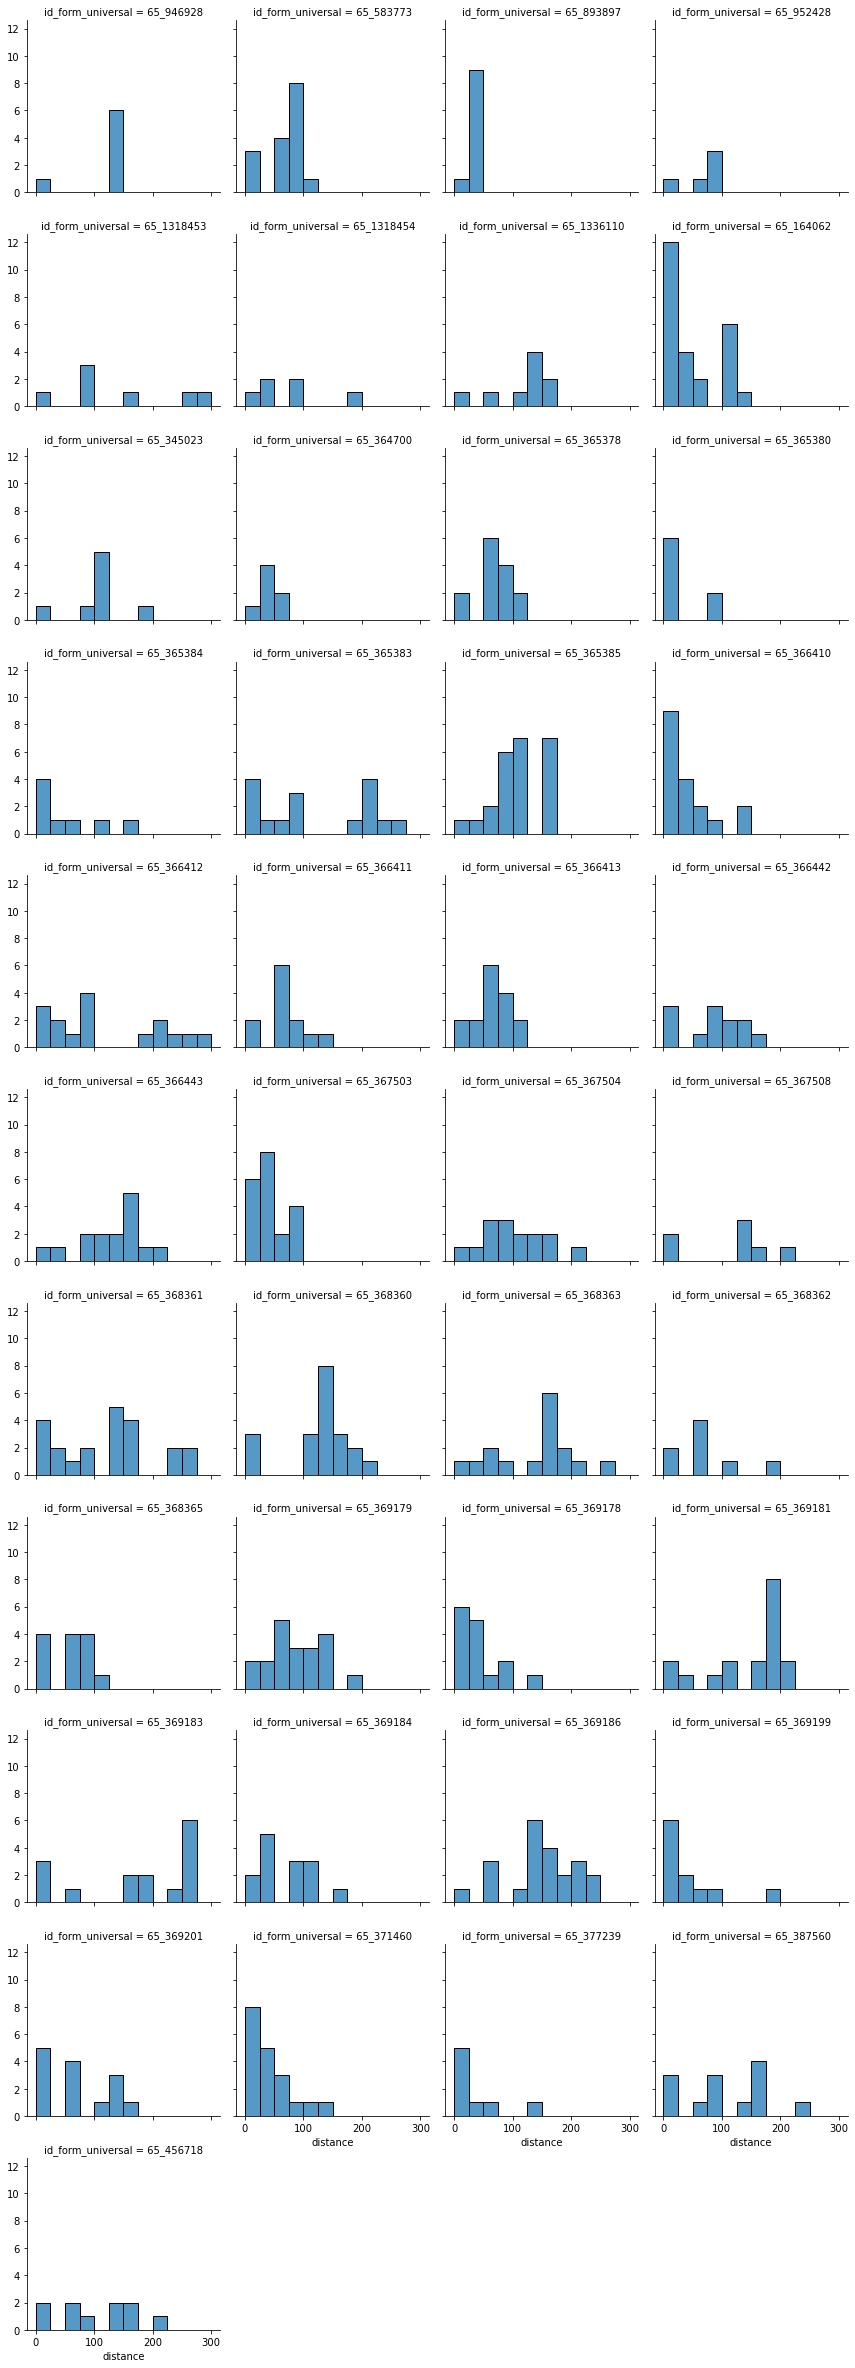

In [87]:
g = sns.FacetGrid(data=epoc_obs, col="id_form_universal", col_wrap=4)
g.map(sns.histplot, "distance", binrange=(0.0, 300.0), binwidth=25.0);


In [123]:
epoc_obs[epoc_obs["id_form_universal"] == "65_1270380"][["id_species", "geom"]]

id_species                            geom
0          501  POINT (917938.167 6460632.498)
1          377  POINT (917938.167 6460632.498)
2          408  POINT (917924.267 6460668.126)
3          408  POINT (917908.879 6460578.571)
4          363  POINT (917887.151 6460622.369)
5          370  POINT (917918.323 6460658.471)
6          493  POINT (917953.262 6460612.026)
7          370  POINT (917945.281 6460620.080)
8          499  POINT (917934.112 6460636.134)
9          408  POINT (917934.112 6460636.134)
10         312  POINT (917762.897 6460514.652)
11         312  POINT (918025.631 6460495.333)
12         312  POINT (917946.008 6460483.307)
13         312  POINT (917967.377 6460666.309)
14         386  POINT (917944.602 6460619.278)
15         408  POINT (917944.602 6460619.278)
16         394  POINT (917926.227 6460590.072)

<AxesSubplot:>

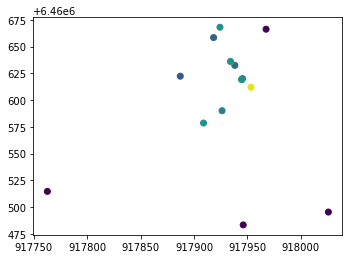

In [127]:
gpd.GeoDataFrame(epoc_obs[epoc_obs["id_form_universal"] == "65_1270380"][["id_species", "geom"]], geometry="geom").plot(column="id_species")